In [ ]:
import os
# file paths
directory = os.getcwd()
DATA_DIR = os.path.abspath("../data")
TRAIN_PATH = os.path.join(DATA_DIR, 'stage1_train')
TEST_PATH = os.path.join(DATA_DIR, 'stage1_test')
INPUT_PATH = os.path.join(directory, 'input')
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [ ]:
import skimage.io
import numpy as np
def read_image_labels(image_id):
    image_file = os.path.join(TRAIN_PATH, "{}", "images", "{}.png").format(image_id, image_id)
    mask_file = os.path.join(TRAIN_PATH,  "{}", "masks", "*.png").format(image_id)
    image = skimage.io.imread(image_file)
    masks = skimage.io.imread_collection(mask_file).concatenate()
    height, width, _ = image.shape
    num_masks = masks.shape[0]
    labels = np.zeros((height, width), np.uint16)
    for index in range(0, num_masks):
        labels[masks[index] > 0] = index + 1
    return image, labels

In [ ]:
from skimage import transform
def data_aug(image, label, angle=30, resize_rate=0.9):
    flip = random.randint(0, 1)
    size = image.shape[0]
    rsize = random.randint(np.floor(resize_rate*size),size)
    w_s = random.randint(0,size - rsize)
    h_s = random.randint(0,size - rsize)
    sh = random.random()/2-0.25
    rotate_angle = random.random()/180*np.pi*angle
    # Create Affine transform
    affine_tf = transform.AffineTransform(shear=sh, rotation=rotate_angle)
    # Apply transform to image data
    image = transform.warp(image, inverse_map=affine_tf, mode='edge')
    label = transform.warp(label, inverse_map=affine_tf, mode='edge')
    # Randomly cropping image frame
    image = image[w_s:w_s+size, h_s:h_s+size, :]
    label = label[w_s:w_s+size, h_s:h_s+size]
    # Randomly flip frame
    if flip:
        image = image[:, ::-1, :]
        label = label[:, ::-1]
    return image, label

In [ ]:
import math
def shear_image(image, label, range=0.25):
    sh = random.uniform(0, range)
    shear_transform = transform.AffineTransform(shear=sh)
    image = transform.warp(image, inverse_map=shear_transform, mode='edge')
    label = transform.warp(label, inverse_map=shear_transform, mode='edge')
    return image, label

In [44]:
def rotate_image(image, label, angle=30):
    rotate_angle = random.random()/180*np.pi*angle
    rotate_transform = transform.AffineTransform(rotation=rotate_angle)
    image = transform.warp(image, inverse_map=rotate_transform, mode='edge')
    label = transform.warp(label, inverse_map=rotate_transform, mode='edge')
    return image, label

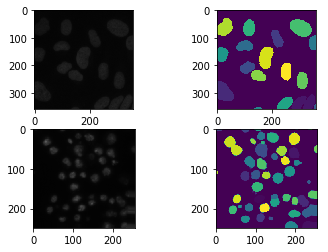

In [51]:
import matplotlib.pyplot as plt
import random
image_ids = os.listdir(TRAIN_PATH)
image_id = image_ids[random.randint(0, len(image_ids))]
image, labels = read_image_labels(image_id)
# original imagea
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(labels)

#new_image, new_labels = data_aug(image, labels, angle=5, resize_rate=0.9)
image, labels = shear_image(image,labels,np.pi*5)
imagae, labels = rotate_image(image, labels, 100)
# augmented images
plt.subplot(223)
plt.imshow(image) #new_image
plt.subplot(224)
plt.imshow(labels) #new_labels
plt.show()

In [ ]:
import warnings
import random
# sample tensorflow model
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [ ]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [ ]:
# Get validation set
validation_ids = []
for i in range(100):
    idx = random.randint(0, len(train_ids))
    rand_id = train_ids[idx]
    train_ids.remove(rand_id)
    validation_ids.append(rand_id)

In [ ]:
import sys
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = os.path.join(TRAIN_PATH, id_)
    image_path = os.path.join(path, 'images', id_ + '.png')
   # img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = imread(image_path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_path = os.path.join(path, 'masks')
    for mask_file in next(os.walk(mask_path))[2]:
        mask_file_path = os.path.join(mask_path, mask_file)
        mask_ = imread(mask_file_path)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

In [ ]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    path = os.path.join(TEST_PATH, id_)
    image_path = os.path.join(path, 'images', id_ + '.png')
    img = imread(image_path)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

In [ ]:
# Get and resize validation images and masks
X_validation = np.zeros((len(validation_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_validation = np.zeros((len(validation_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing validation images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(validation_ids), total=len(validation_ids)):
    path = os.path.join(TRAIN_PATH, id_)
    image_path = os.path.join(path, 'images', id_ + '.png')
   # img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = imread(image_path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_validation[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_path = os.path.join(path, 'masks')
    for mask_file in next(os.walk(mask_path))[2]:
        mask_file_path = os.path.join(mask_path, mask_file)
        mask_ = imread(mask_file_path)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_validation[n] = mask

In [ ]:
def shuffle():
    global images, labels
    p = np.random.permutation(len(X_train))
    images = X_train[p]
    labels = Y_train[p]

In [ ]:
def next_batch(batch_s, iters):
    if(iters == 0):
        shuffle()
    count = batch_s * iters
    return images[count:(count + batch_s)], labels[count:(count + batch_s)]

In [ ]:
import tensorflow as tf
def deconv2d(input_tensor, filter_size, output_size, out_channels, in_channels, name, strides = [1, 1, 1, 1]):
    dyn_input_shape = tf.shape(input_tensor)
    batch_size = dyn_input_shape[0]
    out_shape = tf.stack([batch_size, output_size, output_size, out_channels])
    filter_shape = [filter_size, filter_size, out_channels, in_channels]
    w = tf.get_variable(name=name, shape=filter_shape)
    h1 = tf.nn.conv2d_transpose(input_tensor, w, out_shape, strides, padding='VALID')
    return h1

In [ ]:
def conv2d(input_tensor, depth, kernel, name, strides=(1, 1), padding="VALID"):
    return tf.layers.conv2d(input_tensor, filters=depth, kernel_size=kernel, strides=strides, padding=padding, activation=tf.nn.relu, name=name)

In [ ]:
X = tf.placeholder(tf.float32, [None, 128, 128, 3])
Y_ = tf.placeholder(tf.float32, [None, 128, 128, 1])
lr = tf.placeholder(tf.float32)

net = conv2d(X, 33, 1, "Y0")

net = conv2d(net, 33, 2, "Y1", strides=(2, 2))

net = conv2d(net, 33, 2, "Y2", strides=(2, 2))


net = deconv2d(net, 1, 32, 33, 33, "Y2_deconv")
net = tf.nn.relu(net)

net = deconv2d(net, 2, 64, 33, 33, "Y1_deconv", strides=[1, 2, 2, 1])
net = tf.nn.relu(net)

net = deconv2d(net, 2, 128, 27, 33, "Y0_deconv", strides=[1, 2, 2, 1])
net = tf.nn.relu(net)


logits = deconv2d(net, 1, 128, 1, 27, "logits_deconv")
loss = tf.losses.sigmoid_cross_entropy(Y_, logits)
optimizer = tf.train.AdamOptimizer(lr).minimize(loss)

In [ ]:
# init
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [ ]:
# no augmentation
batch_count = 0
display_count = 1
for i in range(100):
    # training on batches of 10 images with 10 mask images
    if (batch_count > 57):
        batch_count = 0

    batch_X, batch_Y = next_batch(10, batch_count)

    batch_count += 1

    feed_dict = {X: batch_X, Y_: batch_Y, lr: 0.0005}
    loss_value, _ = sess.run([loss, optimizer], feed_dict=feed_dict)

    if (i % 10 == 0):
        print(str(display_count) + " training loss:", str(loss_value))
        display_count += 1

In [ ]:
# with augmentation
batch_count = 0
display_count = 1
for i in range(100):
    # training on batches of 10 images with 10 mask images
    if (batch_count > 57):
        batch_count = 0

    batch_X, batch_Y = next_batch(10, batch_count)

    # transform images in batch
    for j in range(len(batch_X)):
        for k in range(10):
            new_image, new_labels = data_aug(batch_X[j], batch_Y[j])
            np.append(batch_X, new_image)
            np.append(batch_Y, new_labels)

    batch_count += 1

    feed_dict = {X: batch_X, Y_: batch_Y, lr: 0.0005}
    loss_value, _ = sess.run([loss, optimizer], feed_dict=feed_dict)

    if (i % 10 == 0):
        print(str(display_count) + " training loss:", str(loss_value))
        display_count += 1

In [ ]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [ ]:
# take a look at test image
from skimage.io import imshow
import matplotlib.pyplot as plt
ix = random.randint(0, len(X_test))
test_image = X_test[ix]
plt.subplot(121)
imshow(test_image)

test_image = np.reshape(test_image, [-1, 128 , 128, 3])
test_data = {X:test_image}

test_mask = sess.run([logits], feed_dict=test_data)
test_mask = np.reshape(np.squeeze(test_mask), [IMG_WIDTH, IMG_WIDTH, 1])
for i in range(IMG_WIDTH):
    for j in range(IMG_HEIGHT):
            test_mask[i][j] = int(sigmoid(test_mask[i][j])*255)
plt.subplot(122)
imshow(test_mask.squeeze().astype(np.uint8))
plt.show()

In [ ]:
# get validation results
feed_dict = {X: X_validation, Y_: Y_validation, lr: 0.0005}
loss_value, _ = sess.run([loss, optimizer], feed_dict=feed_dict)
print("Validation loss " + str(loss_value))

In [ ]:
# take a look at validation image
# actual image, actual mask, predicted mask
from skimage.io import imshow
import matplotlib.pyplot as plt
ix = random.randint(0, len(X_validation))
val_image = X_validation[ix]
plt.subplot(131)
imshow(val_image)

val_image_id = validation_ids[ix]
_, labels = read_image_labels(val_image_id)
plt.subplot(132)
imshow(labels)

val_image = np.reshape(val_image, [-1, 128 , 128, 3])
test_data = {X:val_image}

test_mask = sess.run([logits], feed_dict=test_data)
test_mask = np.reshape(np.squeeze(test_mask), [IMG_WIDTH, IMG_WIDTH, 1])
for i in range(IMG_WIDTH):
    for j in range(IMG_HEIGHT):
            test_mask[i][j] = int(sigmoid(test_mask[i][j])*255)
plt.subplot(133)
imshow(test_mask.squeeze().astype(np.uint8))
plt.show()
